In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [2]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, a=1., b=1.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0
    # r_c = np.hypot(x_2d - x_c, y_2d - y_c)
    r_c = np.hypot((x_2d - x_c) / a, (y_2d - y_c) / b)
    
    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()


In [3]:
def moca1(u, v, x, y, n_ic, n_jc, r=14):
    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)[0]
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    w = 2*c

    return x0, y0, l, xx, yy, u1, v1, a, b, c, w

In [4]:
X, Y = np.meshgrid(x, y)
nic, njc = 50, 60
r = 14

df_tests = pd.DataFrame({
    'nic': [nic, nic, nic, nic, nic, nic],
    'njc': [54, njc, 66, njc, njc, njc],
    'r': [r, r, r, 8, r, 20]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():

    x0_rel, y0_rel, l_rel, xx_rel, yy_rel, u1_rel, v1_rel, a_rel, b_rel, c_rel, w_rel = moca1(u, v, x, y, nic_rel, njc_rel, r_rel)

    dic_tests[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'l': l_rel, 'xx': xx_rel, 'yy': yy_rel,
        'u1': u1_rel, 'v1': v1_rel, 'a': a_rel, 'b': b_rel,
        'c': c_rel, 'w': w_rel, 'name': test_name
    }

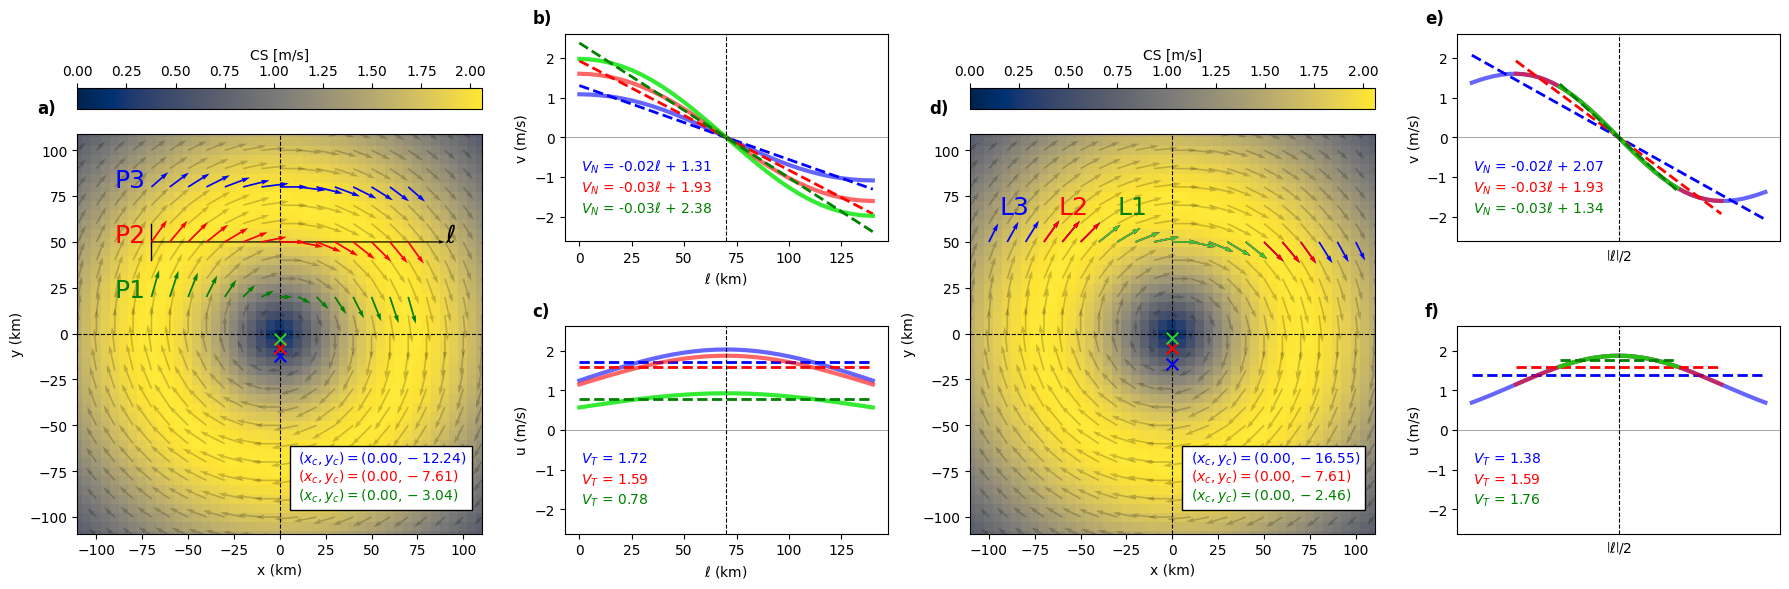

In [21]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

colors = ['limegreen', 'r', 'b']
color = ['g', 'r', 'b']
color_fits = [(0, .9, 0, 0.8), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        if dic['name'] == 'P2':
            # l axis
            ax_main_left.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
            ax_main_left.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
            ax_main_left.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)
        ax_main_left.text(xx[0]-20, yy[0], dic['name'], color=color[i], zorder=3, fontsize=18)
        ax_main_left.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=color[i], zorder=3)
        ax_main_left.scatter(x0, y0, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_left.text(10, -90 + 10*i, fr'$(x_c,y_c)=({np.abs(dic["x0"]):.2f},{dic["y0"]:.2f})$', color=color[i])
        i += 1
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_left.add_patch(rect)
ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

j = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        fit = np.poly1d(np.polyfit(l, v1, 1))
        ax2_left.plot(l, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_left.plot(l, fit(l), color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        # ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_left.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        fit = np.poly1d(np.polyfit(l, u1, 0))
        ax3_left.plot(l, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_left.plot(l, fit(l), color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        # ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {fit[0]:.2f}", transform=ax3_left.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {fit[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        j += 1
        
ax2_left.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel('v (m/s)')
ax2_left.set_xlabel(r'$\ell$ (km)')
ax2_left.text(-0.1, 1.05, 'b)', transform=ax2_left.transAxes, fontsize=12, fontweight='bold')
ax3_left.axvline(l[len(l) // 2], color='k', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel('u (m/s)')
ax3_left.set_xlabel(r'$\ell$ (km)')
ax3_left.text(-0.1, 1.05, 'c)', transform=ax3_left.transAxes, fontsize=12, fontweight='bold')

# Right PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
quiv = ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        ax_main_right.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=colors[i], zorder=5-i)
        ax_main_right.scatter(x0, y0, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_right.text(10, -90 + 10*i, fr'$(x_c,y_c)=({np.abs(dic["x0"]):.2f},{dic["y0"]:.2f})$', color=color[i])

        ax_main_right.text(xx[0]-i*2 +10, yy[0]+15, dic['name'], color=color[i], zorder=3, fontsize=18)
 
        i += 1
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_right.add_patch(rect)
ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

j = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])

        # just for label
        fit = np.poly1d(np.polyfit(l, v1, 1))
        # ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_right.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])
        fit = np.poly1d(np.polyfit(l, u1, 0))
        # ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {fit[0]:.2f}", transform=ax3_right.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {fit[0]:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        l_big = dic_tests['L3']['l']
        l = l + .5 * np.abs(l_big[-1] - l[-1])
        
        fit = np.poly1d(np.polyfit(l, v1, 1))
        ax2_right.plot(l, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_right.plot(l, fit(l), color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        fit = np.poly1d(np.polyfit(l, u1, 0))
        ax3_right.plot(l, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_right.plot(l, fit(l), color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        j += 1

ax2_right.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel('v (m/s)')
ax2_right.text(-0.1, 1.05, 'e)', transform=ax2_right.transAxes, fontsize=12, fontweight='bold')
# ax2_right.set_xlabel(r'$\ell$')
ax2_right.set_xlabel(r'$\left|\ell\right|/2$')
ax2_right.set_xticks([])
ax3_right.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel('u (m/s)')
ax3_right.set_xlabel(r'$\ell$ (km)')
ax3_right.text(-0.1, 1.05, 'f)', transform=ax3_right.transAxes, fontsize=12, fontweight='bold')
ax3_right.set_xlabel(r'$\left|\ell\right|/2$')
ax3_right.set_xticks([])

axs = [ax2_left, ax3_left, ax2_right, ax3_right]
ymin, ymax = np.inf, -np.inf
for ax in axs:
    ymin = min(ymin, ax.get_ylim()[0])
    ymax = max(ymax, ax.get_ylim()[1])

for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

## Modified Version

In [6]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept

def cubic_interpolate(x, y, root):
    coeffs = np.polyfit(x, y, 3)
    return np.polyval(coeffs, root)

def moca1_mod(u, v, x, y, n_ic, n_jc, r=20):
    # Extract vertical profile at column n_jc
    u1 = u[n_ic - r:n_ic + r + 1, n_jc]
    v1 = v[n_ic - r:n_ic + r + 1, n_jc]
    xx = x[n_ic - r:n_ic + r + 1]
    base = xx[0]
    l = xx - base
    yy = np.full_like(xx, y[n_jc])
    
    root = find_root(l, v1)
    c, b = tang_at_root(l, v1, root)  # c: slope, b: intercept
    a = cubic_interpolate(l, u1, root)
    
    x0 = -b / c + base
    y0 = a / c + yy[0]
    w = 2 * c
    
    return x0, y0, l, xx, yy, u1, v1, a, b, c, w 



In [7]:
X, Y = np.meshgrid(x, y)
nic, njc = 50, 60
r = 14

dic_tests_mod = {}
for test_name, (nic_rel, njc_rel, r_rel) in df_tests.iterrows():

    x0_rel, y0_rel, l_rel, xx_rel, yy_rel, u1_rel, v1_rel, a_rel, b_rel, c_rel, w_rel = moca1_mod(u, v, x, y, nic_rel, njc_rel, r_rel)

    dic_tests_mod[test_name] = {
        'x0': x0_rel, 'y0': y0_rel, 'l': l_rel, 'xx': xx_rel, 'yy': yy_rel,
        'u1': u1_rel, 'v1': v1_rel, 'a': a_rel, 'b': b_rel,
        'c': c_rel, 'w': w_rel, 'name': test_name
    }

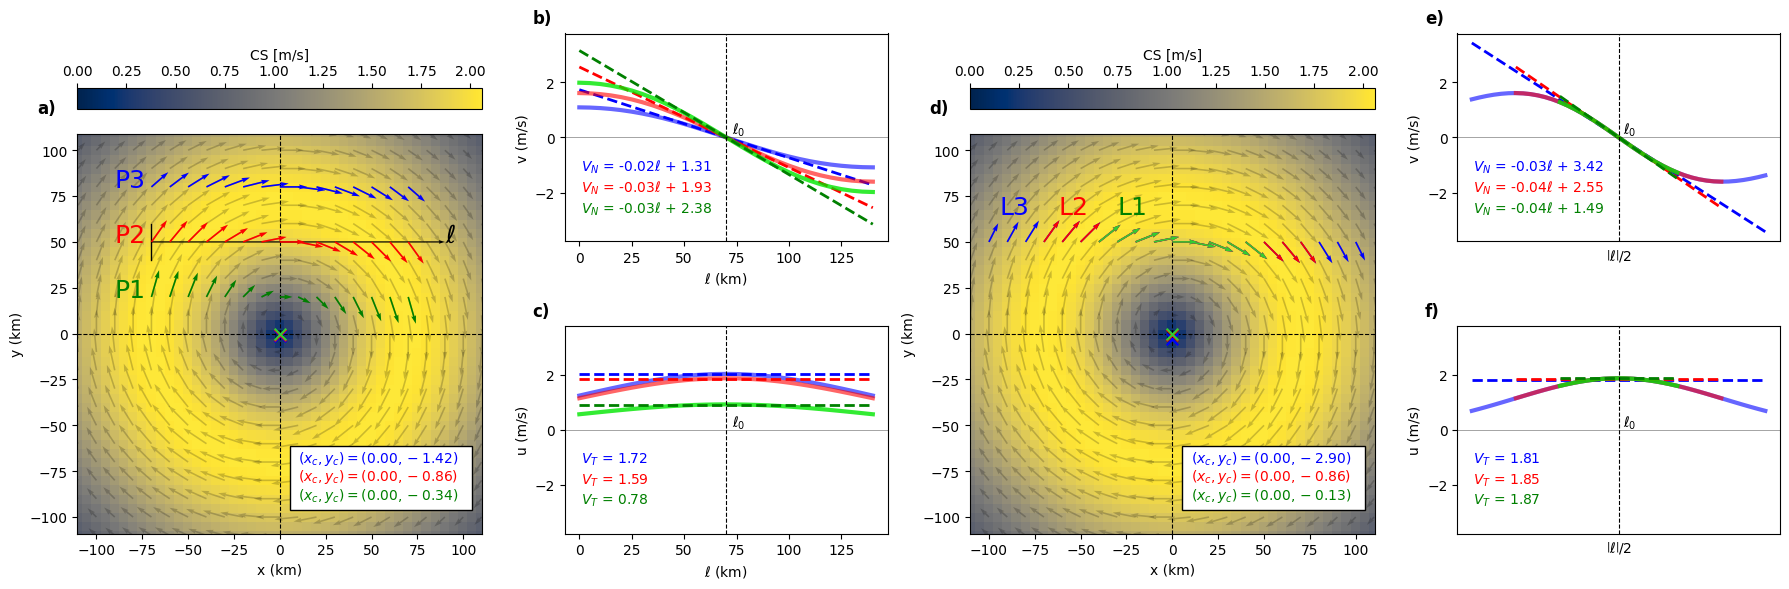

In [22]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

colors = ['limegreen', 'r', 'b']
color = ['g', 'r', 'b']
color_fits = [(0, .9, 0, 0.8), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
i = 0
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        if dic['name'] == 'P2':
            # l axis
            ax_main_left.quiver(xx[0], yy[0], xx[-1] - xx[0] + 20, yy[-1] - yy[0], angles='xy', scale_units='xy', scale=1, color='k', width=0.003, zorder=1)
            ax_main_left.plot([xx[0], xx[0]], [yy[0] - 10, yy[0] + 10], color='k', linewidth=1)
            ax_main_left.text(xx[-1] + 20, yy[0], r'$\ell$', fontsize=18)
        ax_main_left.text(xx[0]-20, yy[0], dic['name'], color=color[i], zorder=3, fontsize=18)
        ax_main_left.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=color[i], zorder=3)
        ax_main_left.scatter(x0, y0, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_left.text(10, -90 + 10*i, fr'$(x_c,y_c)=({np.abs(dic["x0"]):.2f},{dic["y0"]:.2f})$', color=color[i])
        i += 1
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_left.add_patch(rect)
ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

# color_fits = [(0, 1, 0, 0.6), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
j = 0
for dic in dic_tests_mod.values():
    if 'P' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        fit = np.poly1d(np.polyfit(l, v1, 1))

        root = find_root(l, v1)
        c, b = tang_at_root(l, v1, root)
        a = cubic_interpolate(l, u1, root)

        p_v1 = c*l + b
        p_u1 = [a]*len(l)

        ax2_left.plot(l, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_left.plot(l, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        # ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_left.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {fit[1]:.2f}$\ell$ + {fit[0]:.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        fit = np.poly1d(np.polyfit(l, u1, 0))
        ax3_left.plot(l, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_left.plot(l, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        # ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {fit[0]:.2f}", transform=ax3_left.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {fit[0]:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        j += 1

ax2_left.text(73, .13, r'$\ell_0$')
ax3_left.text(73, .13, r'$\ell_0$')
        
ax2_left.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel('v (m/s)')
ax2_left.set_xlabel(r'$\ell$ (km)')
ax2_left.text(-0.1, 1.05, 'b)', transform=ax2_left.transAxes, fontsize=12, fontweight='bold')
ax3_left.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel('u (m/s)')
ax3_left.set_xlabel(r'$\ell$ (km)')
ax3_left.text(-0.1, 1.05, 'c)', transform=ax3_left.transAxes, fontsize=12, fontweight='bold')

# Right PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
quiv = ax_main_right.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

i = 0
for dic in dic_tests_mod.values():
    if 'L' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])
        ax_main_right.quiver(xx[::spacing], yy[::spacing], u1[::spacing], v1[::spacing], scale=scale, width=width, color=colors[i], zorder=5-i)
        ax_main_right.scatter(x0, y0, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_right.text(10, -90 + 10*i, fr'$(x_c,y_c)=({np.abs(dic["x0"]):.2f},{dic["y0"]:.2f})$', color=color[i])

        ax_main_right.text(xx[0]-i*2 +10, yy[0]+15, dic['name'], color=color[i], zorder=3, fontsize=18)
 
        i += 1
x_pos, y_pos = 0.75, 0.14
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black')
ax_main_right.add_patch(rect)
ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

j = 0
for dic in dic_tests_mod.values():
    if 'L' in dic['name']:
        x0, y0, l, xx, yy, u1, v1, a, b, c, w = (dic[k] for k in ['x0', 'y0', 'l', 'xx', 'yy', 'u1', 'v1', 'a', 'b', 'c', 'w'])

        root = find_root(l, v1)
        c, b = tang_at_root(l, v1, root)
        a = cubic_interpolate(l, u1, root)

        # just for label
        # ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{v}}$ = {c:.2f}$\ell$ + {b:.2f}", transform=ax2_right.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        # ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$\widetilde{{u}}$ = {a:.2f}", transform=ax3_right.transAxes,
        #  fontsize=10, verticalalignment='top', color=color[j])
        ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}$\ell$ + {b:.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])
        ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {a:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        l_big = dic_tests_mod['L3']['l']
        l = l + .5 * np.abs(l_big[-1] - l[-1])

        root = find_root(l, v1)
        c, b = tang_at_root(l, v1, root)
        a = cubic_interpolate(l, u1, root)

        p_v1 = c*l + b
        p_u1 = [a]*len(l)

        ax2_right.plot(l, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_right.plot(l, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        ax3_right.plot(l, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_right.plot(l, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        j += 1

ax2_right.text(103, .13, r'$\ell_0$')
ax3_right.text(103, .13, r'$\ell_0$')

ax2_right.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel('v (m/s)')
ax2_right.text(-0.1, 1.05, 'e)', transform=ax2_right.transAxes, fontsize=12, fontweight='bold')
ax2_right.set_xlabel(r'$\left|\ell\right|/2$')
ax2_right.set_xticks([])
ax3_right.axvline(l[len(l) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel('u (m/s)')
ax3_right.set_xlabel(r'$\ell$ (km)')
ax3_right.text(-0.1, 1.05, 'f)', transform=ax3_right.transAxes, fontsize=12, fontweight='bold')
ax3_right.set_xlabel(r'$\left|\ell\right|/2$')
ax3_right.set_xticks([])

axs = [ax2_left, ax3_left, ax2_right, ax3_right]
ymin, ymax = np.inf, -np.inf
for ax in axs:
    ymin = min(ymin, ax.get_ylim()[0])
    ymax = max(ymax, ax.get_ylim()[1])

for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [9]:
df = pd.DataFrame(columns=['x0', 'y0'])
for dic in dic_tests.values():
    df.loc[len(df)] = {'x0': dic['x0'], 'y0': dic['y0']}
df.index = dic_tests.keys()

df_mod = pd.DataFrame(columns=['x0m', 'y0m'])
for dic in dic_tests_mod.values():
    df_mod.loc[len(df_mod)] = {'x0m': dic['x0'], 'y0m': dic['y0']}
df_mod.index = dic_tests_mod.keys()

df_results = pd.concat([df, df_mod], axis=1)

df_results['ERR'] = np.hypot(df_results['x0'], df_results['y0'])
df_results['ERRm'] = np.hypot(df_results['x0m'], df_results['y0m'])

df_results['%'] = (df_results['ERR'] - df_results['ERRm']) / df_results['ERR'] * 100

df_results

,x0,y0,x0m,y0m,ERR,ERRm,%
P1,1.421085e-14,-3.037585,-4.263256e-14,-0.335401,3.037585,0.335401,88.958309
P2,0.000000e+00,-7.614122,-1.421085e-14,-0.856297,7.614122,0.856297,88.753834
P3,0.000000e+00,-12.242516,-4.263256e-14,-1.422967,12.242516,1.422967,88.376842
L1,0.000000e+00,-2.462464,-7.105427e-15,-0.128353,2.462464,0.128353,94.787624
L2,0.000000e+00,-7.614122,-1.421085e-14,-0.856297,7.614122,0.856297,88.753834
L3,-1.421085e-14,-16.547954,1.136868e-13,-2.896592,16.547954,2.896592,82.495770


In [10]:
df_results.mean()['%']

np.float64(88.68770226778439)

## ROMS


In [11]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))


In [12]:
df_MOCA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]
    
            xc, yc, _, _, _, _, _, _, _, _, w = moca1_mod(u_roms, v_roms, x_roms, y_roms, nic, njc, r_roms)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_MOCA.loc[len(df_MOCA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x_roms - xc).argmin()
                    njc = np.abs(y_roms - yc).argmin()
                    
                else:
                    break
            else:
                break

In [13]:
eddy1 = [the_frontier_eddies[0]] * 3 
t1 = [0, 5, 15, 25, 29]
z1 = [3, 0, 3, 20, 0]

eddy2 = [the_frontier_eddies[1]] * 9
t2 = [0, 10, 10, 10, 10, 20, 29]
z2 = [20, 3, 15, 20, 5, 5, 20]

eddy3 = [the_frontier_eddies[2]] * 14
t3 = [0, 5, 10, 10, 15, 15, 15, 25, 25, 25, 25, 25, 29, 29]
z3 = [5, 0, 5, 15, 0, 3, 9, 0, 3, 9, 15, 20, 15, 20]

eddy4 = [the_frontier_eddies[3]] * 10
t4 = [0, 0, 0, 5, 10, 10, 15, 20, 20, 29]
z4 = [5, 8, 20, 20, 3, 20, 20, 8, 20, 20]

df_show_offs = pd.DataFrame({
    'Eddy': eddy1 + eddy2 + eddy3 + eddy4,
    'Day': t1 + t2 + t3 + t4,
    'z': z1 + z2 + z3 + z4
    })

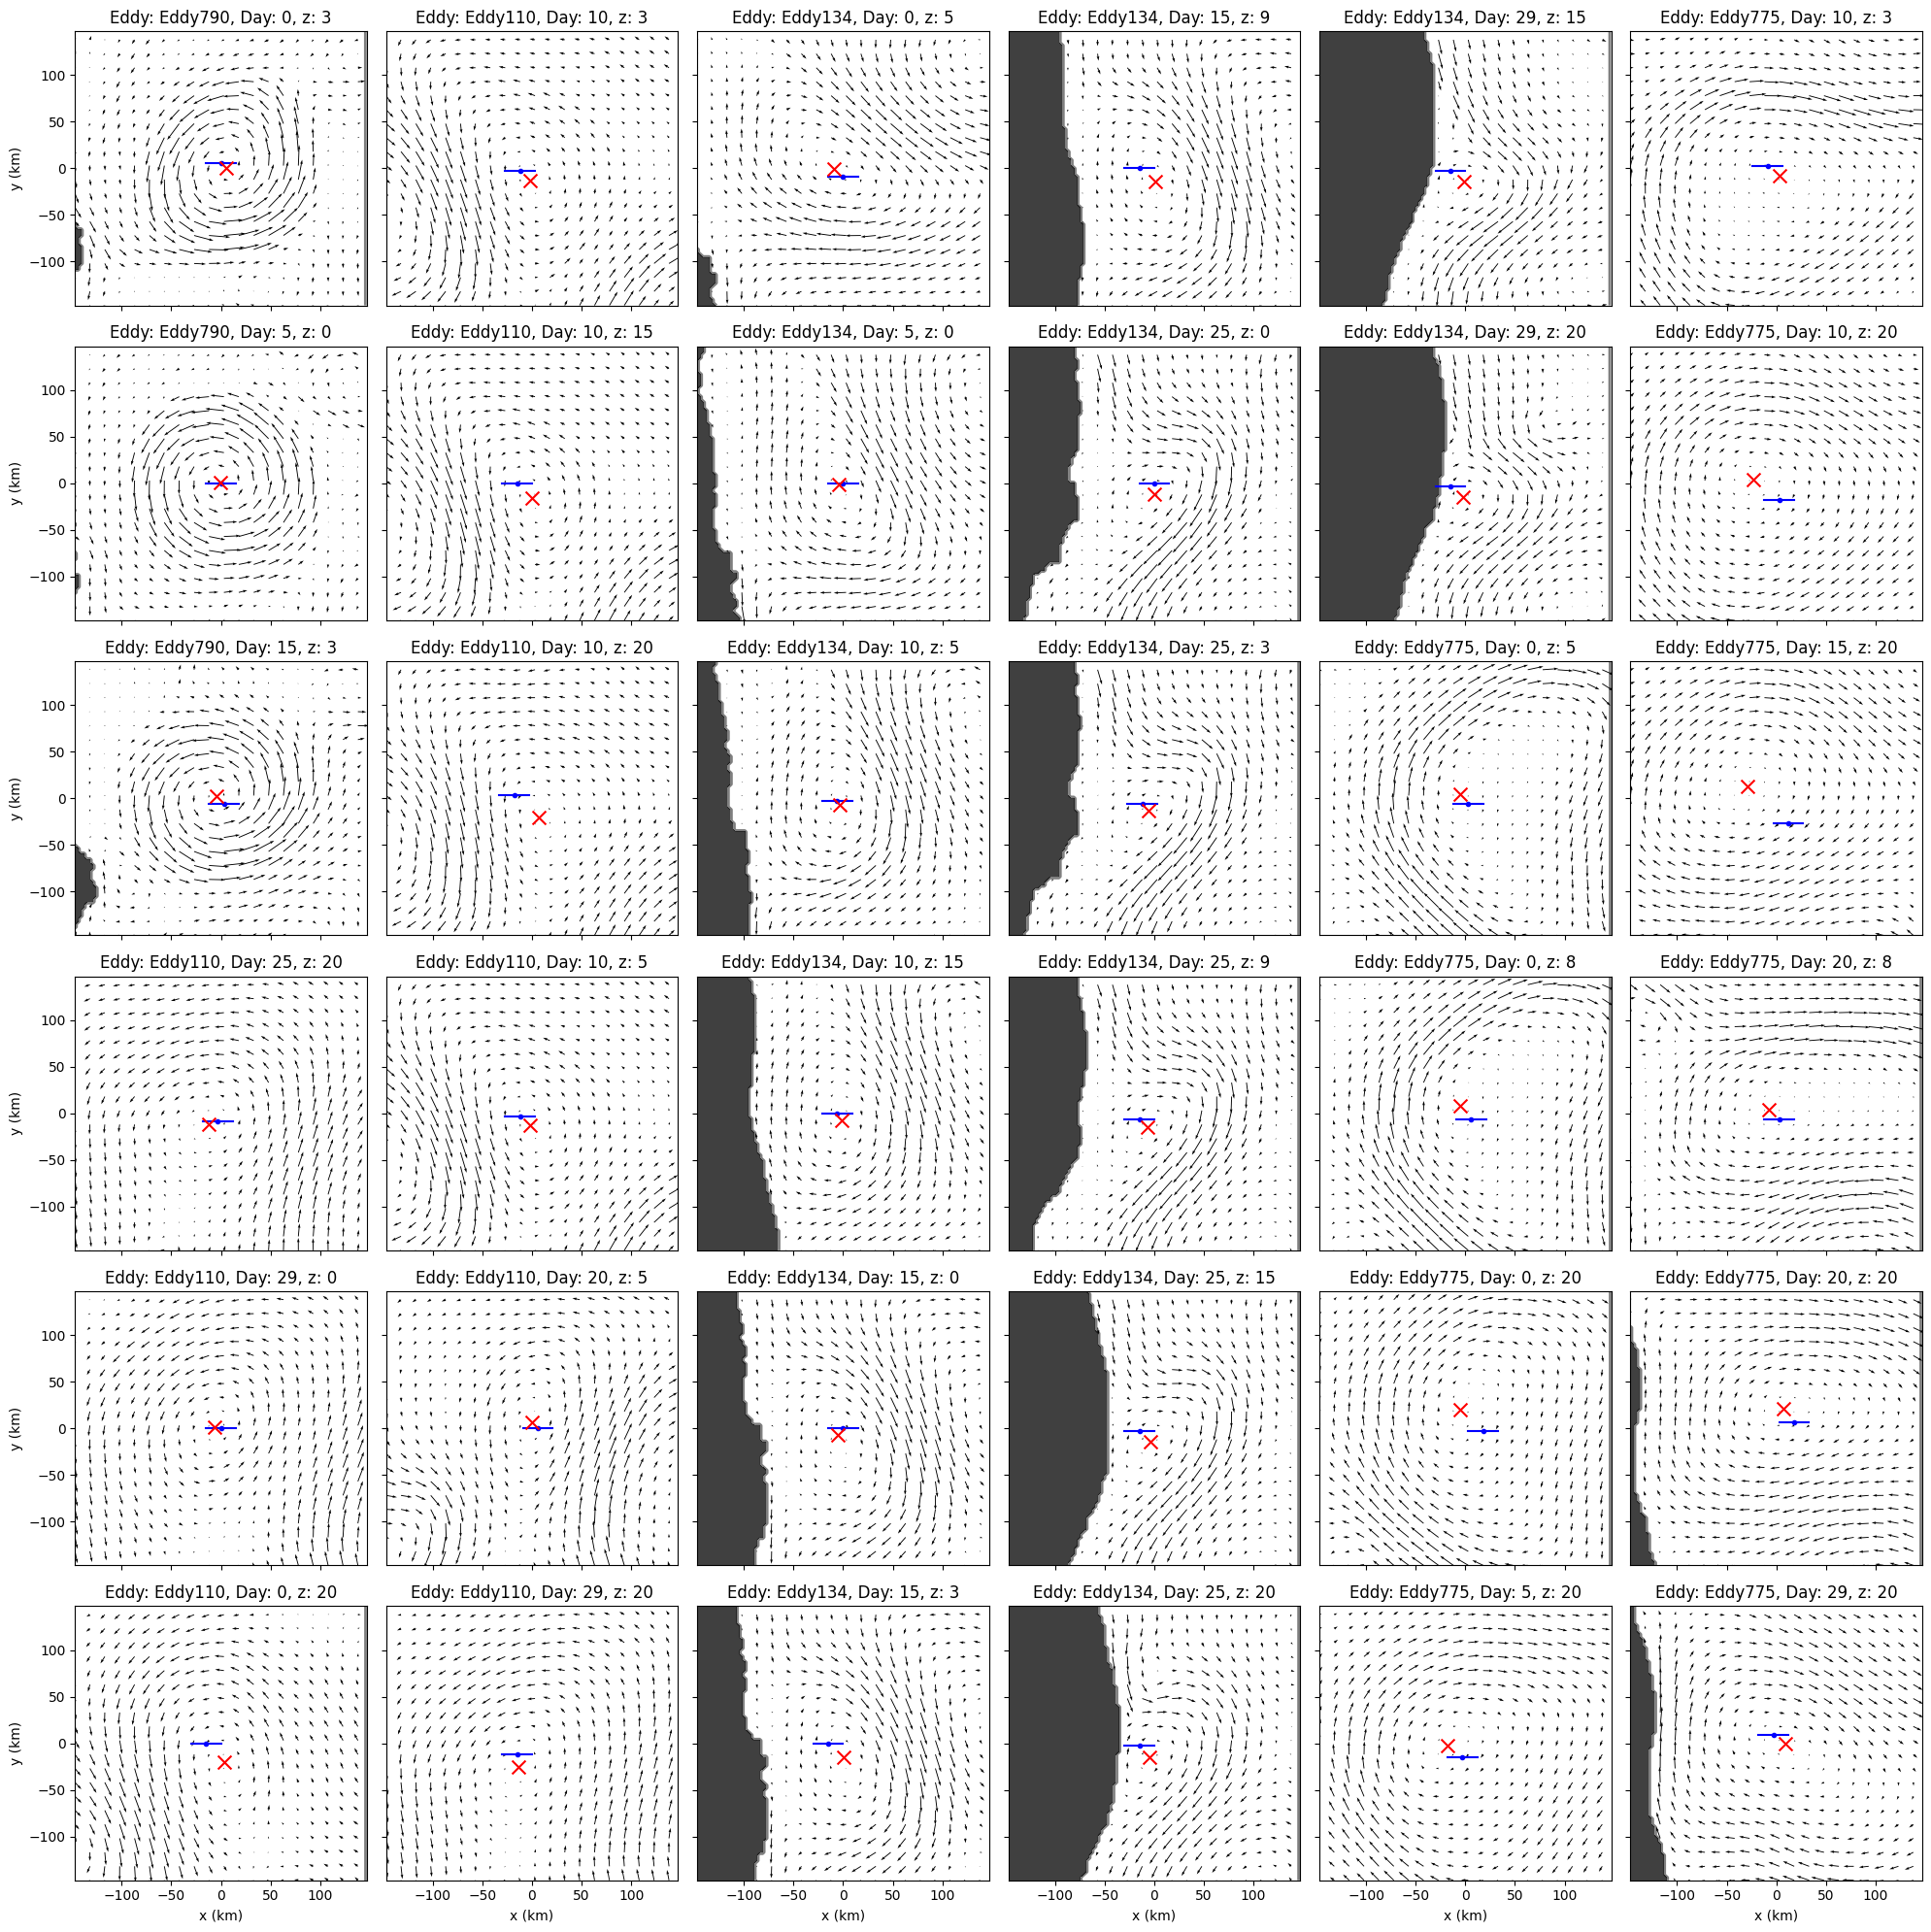

In [14]:
rows, cols = 6, 6

fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharey=True, sharex=True)

for k in range(len(df_show_offs)):

    ax = axs[k % rows, k//rows]

    df_rel = df_show_offs.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]


    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    # ax.plot([X_roms[nic-r, njc], X_roms[nic+r, njc]], [Y_roms[nic-r, njc], Y_roms[nic+r, njc]], 'b', zorder=3)
    ax.plot(X_roms[nic, njc], Y_roms[nic, njc], marker='.', color='b')
    ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

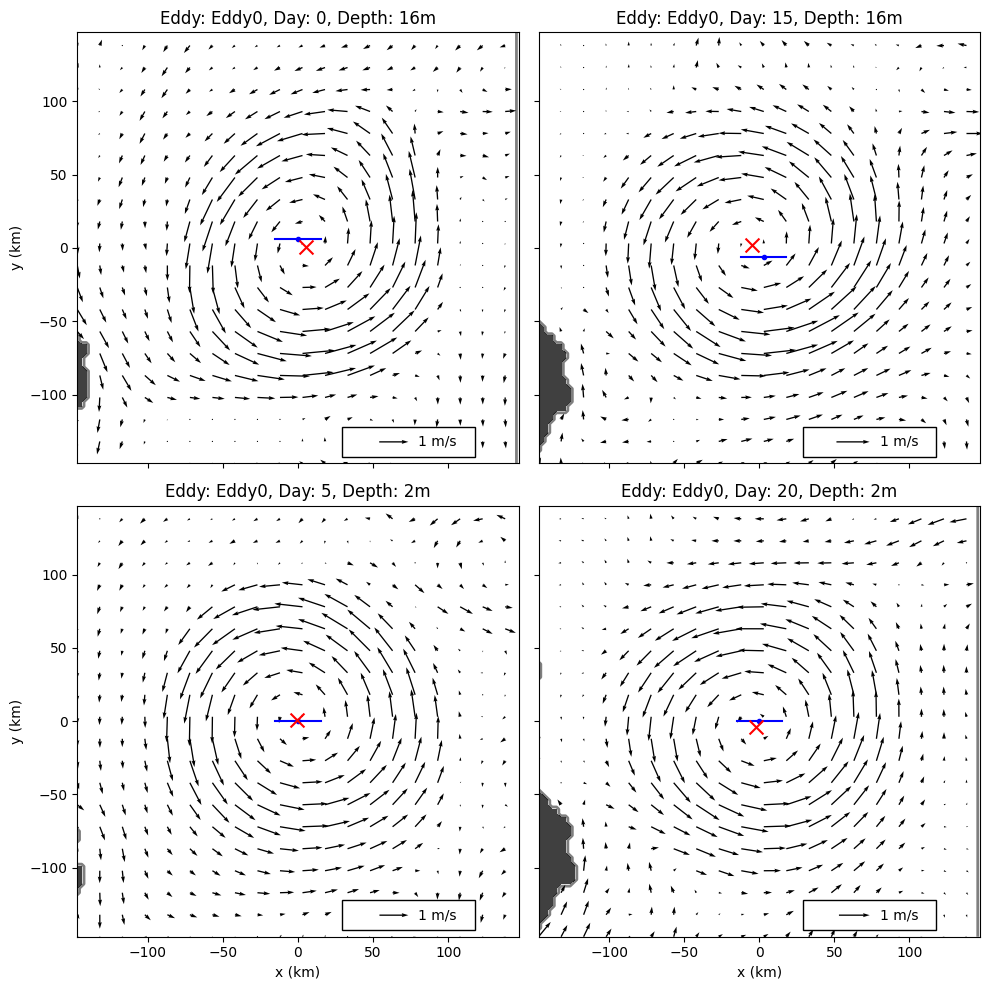

In [15]:
df_MOCA_PAPER = pd.DataFrame({
    'Eddy': ['Eddy790', 'Eddy790', 'Eddy790', 'Eddy790'],
    'Day': [0, 5, 15, 20],
    'z': [3, 0, 3, 0]
    })

rows, cols = 2, 2

fig, axs = plt.subplots(rows, cols, figsize=(10, 10), sharey=True, sharex=True)

for k in range(len(df_MOCA_PAPER)):

    ax = axs[k % rows, k//rows]

    df_rel = df_MOCA_PAPER.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]


    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    spacing = 5
    quiv = ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    ax.plot(X_roms[nic, njc], Y_roms[nic, njc], marker='.', color='b')
    ax.plot([X_roms[nic, njc-r_roms], X_roms[nic, njc+r_roms]], [Y_roms[nic, njc-r_roms], Y_roms[nic, njc+r_roms]], 'b', zorder=3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: Eddy{the_frontier_eddies.index(eddy)}, Day: {t}, Depth: {-round(z_r[150, 150, depth_lvl])}m')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.text(-0.1, 1.05, 'd)', transform=ax.transAxes, fontsize=12, fontweight='bold')

    # ax.axis('equal')

    magnitude = 1
    x_pos, y_pos = 0.75, 0.05  
    box_width = 0.3  # Adjust width as needed
    box_height = 0.07  # Adjust height as needed
    rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                           box_width, box_height, transform=ax.transAxes,
                           facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    ax.quiverkey(quiv, X=x_pos, Y=y_pos, U=magnitude,
                 label=f'{magnitude} m/s', labelpos='E')

plt.tight_layout()
plt.show()